In [1]:
import os

os.environ["PYSYN_CDBS"] = "/home/ruizhew/POSEIDON/inputs/stellar_grids/"
os.environ["POSEIDON_input_data"] = "/home/ruizhew/POSEIDON/inputs/"

In [2]:
from __future__ import absolute_import, unicode_literals, print_function
from POSEIDON.high_res import (
    fast_filter,
    loglikelihood_sysrem,
    get_rot_kernel,
    fit_uncertainties,
)
import math, os
import numpy as np
import pickle
import pickle
from scipy import constants
from numba import jit
from astropy.io import fits
from scipy import interpolate
from POSEIDON.core import (
    create_star,
    create_planet,
    define_model,
    make_atmosphere,
    read_opacities,
    wl_grid_constant_R,
    wl_grid_line_by_line,
    compute_spectrum,
)
from POSEIDON.constants import R_Sun
from POSEIDON.visuals import plot_stellar_flux
from POSEIDON.constants import R_J, M_J
import numpy as np
from spectres import spectres
from tqdm import tqdm
from multiprocessing import Pool
import time

R_s = 1.458 * R_Sun  # Stellar radius (m)
T_s = 6776  # Stellar effective temperature (K)
Met_s = 0.13  # Stellar metallicity [log10(Fe/H_star / Fe/H_solar)]
log_g_s = 4.24  # Stellar log surface gravity (log10(cm/s^2) by convention)

# Create the stellar object
star = create_star(R_s, T_s, log_g_s, Met_s, stellar_grid="phoenix")

F_s = star["F_star"]
wl_s = star["wl_star"]
R_s = star["R_s"]


# ***** Define planet properties *****#

planet_name = "WASP-121b"  # Planet name used for plots, output files etc.

R_p = 1.753 * R_J  # Planetary radius (m)
M_p = 1.157 * M_J  # Mass of planet (kg)
g_p = 10 ** (2.97 - 2)  # Gravitational field of planet (m/s^2)
T_eq = 2450  # Equilibrium temperature (K)

# Create the planet object
planet = create_planet(planet_name, R_p, mass=M_p, gravity=g_p, T_eq=T_eq)

# If distance not specified, use fiducial value
if planet["system_distance"] is None:
    planet["system_distance"] = 1  # This value only used for flux ratios, so it cancels
d = planet["system_distance"]

# ***** Define model *****#

model_name = "Injection-retrieval-Fe-6"  # Model name used for plots, output files etc.

bulk_species = ["H2", "He"]  # H2 + He comprises the bulk atmosphere
param_species = ["Fe"]  # H2O, CO as in Brogi & Line

# Create the model object
model = define_model(model_name, bulk_species, param_species, PT_profile="Madhu")

# Check the free parameters defining this model
print("Free parameters: " + str(model["param_names"]))


# ***** Wavelength grid *****#

wl_min = 0.37  # Minimum wavelength (um)
wl_max = 0.51  # Maximum wavelength (um)
R = 250000  # Spectral resolution of grid

# wl = wl_grid_line_by_line(wl_min, wl_max)
wl = wl_grid_constant_R(wl_min, wl_max, R)

# ***** Read opacity data *****#

opacity_treatment = "opacity_sampling"

# Define fine temperature grid (K)
T_fine_min = 400  # 400 K lower limit suffices for a typical hot Jupiter
T_fine_max = 3500  # 2000 K upper limit suffices for a typical hot Jupiter
T_fine_step = 20  # 20 K steps are a good tradeoff between accuracy and RAM

T_fine = np.arange(T_fine_min, (T_fine_max + T_fine_step), T_fine_step)

# Define fine pressure grid (log10(P/bar))
log_P_fine_min = -12.0  # 1 ubar is the lowest pressure in the opacity database
log_P_fine_max = 2  # 100 bar is the highest pressure in the opacity database
log_P_fine_step = 0.2  # 0.2 dex steps are a good tradeoff between accuracy and RAM

log_P_fine = np.arange(
    log_P_fine_min, (log_P_fine_max + log_P_fine_step), log_P_fine_step
)

# Now we can pre-interpolate the sampled opacities (may take up to a minute)
opac = read_opacities(model, wl, opacity_treatment, T_fine, log_P_fine)

# Specify the pressure grid of the atmosphere
P_min = 1e-12  # 0.1 ubar
P_max = 100  # 100 bar
N_layers = 100  # 100 layers

# We'll space the layers uniformly in log-pressure
P = np.logspace(np.log10(P_max), np.log10(P_min), N_layers)

# Specify the reference pressure and radius
P_ref = 1e-5  # Reference pressure (bar)
R_p_ref = R_p  # Radius at reference pressure

params = (-6, 0.3, 0.3, -1, -2, 1, 3000)
log_Fe, a1, a2, log_P1, log_P2, log_P3, T_ref = params

# Provide a specific set of model parameters for the atmosphere
PT_params = np.array(
    [a1, a2, log_P1, log_P2, log_P3, T_ref]
)  # a1, a2, log_P1, log_P2, log_P3, T_deep
log_X_params = np.array([[log_Fe]])

atmosphere = make_atmosphere(
    planet, model, P, P_ref, R_p_ref, PT_params, log_X_params, P_param_set=1
)

# Generate planet surface flux
spectrum = compute_spectrum(
    planet, star, model, atmosphere, opac, wl, spectrum_type="transmission"
)

Free parameters: ['R_p_ref' 'a1' 'a2' 'log_P1' 'log_P2' 'log_P3' 'T_ref' 'log_Fe']
Reading in cross sections in opacity sampling mode...
H2-H2 done
H2-He done
Fe done
Opacity pre-interpolation complete.


In [3]:
model_name = "Injection Retrieval Fe-6"  # Model name used for plots, output files etc.

bulk_species = ["H2", "He"]  # H2 + He comprises the bulk atmosphere
param_species = []  # H2O, CO as in Brogi & Line

# Create the model object
model = define_model(model_name, bulk_species, param_species, PT_profile="Madhu")

# Check the free parameters defining this model
print("Free parameters: " + str(model["param_names"]))

params = (0.3, 0.3, -1, -2, 1, 3000)
a1, a2, log_P1, log_P2, log_P3, T_ref = params

# Provide a specific set of model parameters for the atmosphere
PT_params = np.array(
    [a1, a2, log_P1, log_P2, log_P3, T_ref]
)  # a1, a2, log_P1, log_P2, log_P3, T_deep
log_X_params = np.array([[log_Fe]])

atmosphere = make_atmosphere(
    planet, model, P, P_ref, R_p_ref, PT_params, log_X_params, P_param_set=1
)

# Generate planet surface flux
continuum_spectrum = compute_spectrum(
    planet, star, model, atmosphere, opac, wl, spectrum_type="transmission"
)

Free parameters: ['R_p_ref' 'a1' 'a2' 'log_P1' 'log_P2' 'log_P3' 'T_ref']


In [4]:
from POSEIDON.utility import read_high_res_data
from POSEIDON.high_res import fit_uncertainties
import numpy as np
import matplotlib.pyplot as plt

output_data_dir = "./data/WASP-121b-injection-a10/"
os.makedirs(output_data_dir, exist_ok=True)
# These data are both in the rest frame of the star. The blue data are aligned with cross-correlation to stellar lines, and the red data are aligned via cross-correlation with a telluric template (however, in the latter case we also shift/interpolate according to the barycentric and systemic velocities to compensate)
al = np.load("./data/WASP-121b/aligned_C_arrays.npz")
# And the aligned data are stored as:
C, Ce = al["aligned/blue/C"], al["aligned/blue/Ce"]  # etc, replace blue with redl/redu

# And just to be extra confusing, I've already stripped out the 70,71,72 frames. (But not the outer orders)
wl_grid, _ = pickle.load(open("./data/WASP-121b/data_raw.pic", "rb"))
phi = pickle.load(open("./data/WASP-121b/phi.pic", "rb"))
transit_weight = pickle.load(open("./data/WASP-121b/transit_weight.pic", "rb"))

In [5]:
from scipy.ndimage import gaussian_filter1d, median_filter

W_conv = 3
a = 10
# spectrum_broadened = gaussian_filter1d(spectrum, W_conv)
# spectrum_broadeneds.append(spectrum)

# spectrum_broadened = gaussian_filter1d(
#     (spectrum - continuum_spectrum) * a + continuum_spectrum, W_conv
# )

spectrum_broadened = (spectrum - continuum_spectrum) * a + continuum_spectrum

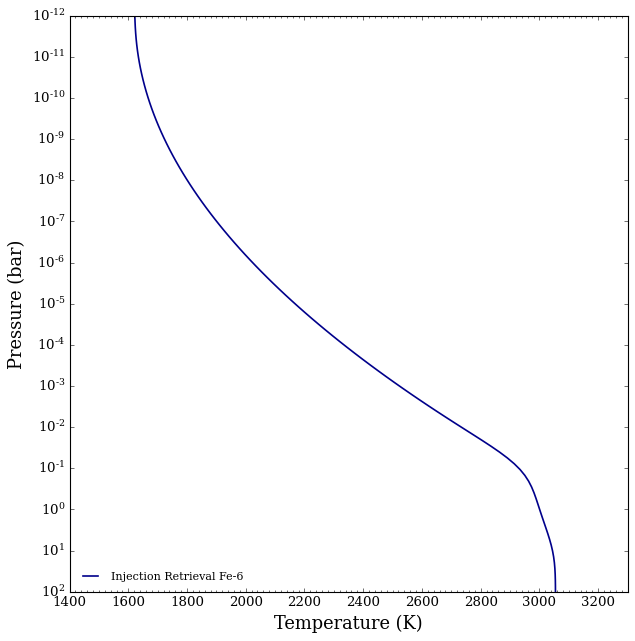

In [6]:
from POSEIDON.visuals import plot_PT

a = plot_PT(planet, model, atmosphere)

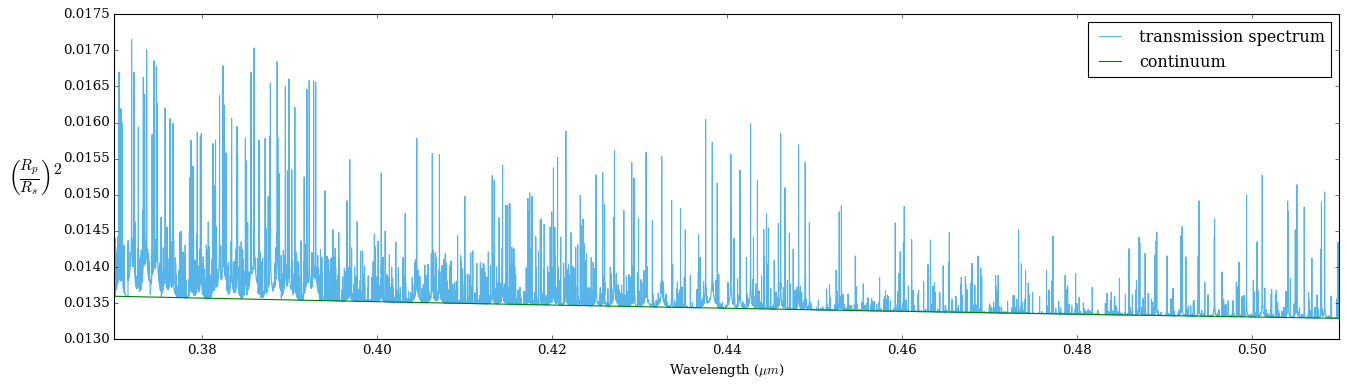

In [7]:
order_i = 15
wl_to_plot = wl_grid[order_i]
spectrum_to_plot = np.interp(wl_to_plot, wl, spectrum_broadened)
continuum_to_plot = np.interp(wl_to_plot, wl, continuum_spectrum)
plt.figure(figsize=(17, 5))
plt.plot(wl, spectrum, label="transmission spectrum", color="#56B4E9")
plt.plot(wl, continuum_spectrum, label="continuum", color="green")
plt.xlim(np.min(wl), np.max(wl))
plt.xlabel(r"Wavelength ($\mu m$)")
plt.ylabel(
    r"$\left( \frac{R_p}{R_s} \right)^2$",
    rotation=0,
    verticalalignment="center",
    fontsize=20,
    labelpad=25,
)
plt.legend()
plt.tight_layout()
plt.ticklabel_format(useOffset=False)

In [8]:
new_phi_index = np.arange(len(phi) + 3)
# 0...132
phi_index = np.delete(np.arange(len(phi) + 3), [69, 70, 71])
new_phi = np.interp(new_phi_index, phi_index, phi)

In [9]:
# phi = new_phi
phi = pickle.load(open("./data/WASP-121b/phi.pic", "rb"))
V_sys = -20
K_p = -200
d_phi = 0
RV_p = V_sys + K_p * np.sin(
    2 * np.pi * (phi + d_phi)
)  # V_sys is an additive term around zero
dl_p = RV_p * 1e3 / constants.c  # delta lambda, for shifting
# cs_p = interpolate.splrep(wl, spectrum_broadened, s=0.0)

In [10]:
N_order, N_phi, N_wl = C.shape

models_shifted = np.zeros(C.shape)  # "shifted" model spectra array at each phase

for i in range(N_order):
    for j in range(N_phi):
        wl_shifted_p = wl_grid[i] * (1.0 - dl_p[j])
        Fp = np.interp(wl_shifted_p, wl, spectrum_broadened)
        models_shifted[i][j] = ((1 - transit_weight[j])) / np.max(
            1 - transit_weight
        ) * (-Fp) + 1

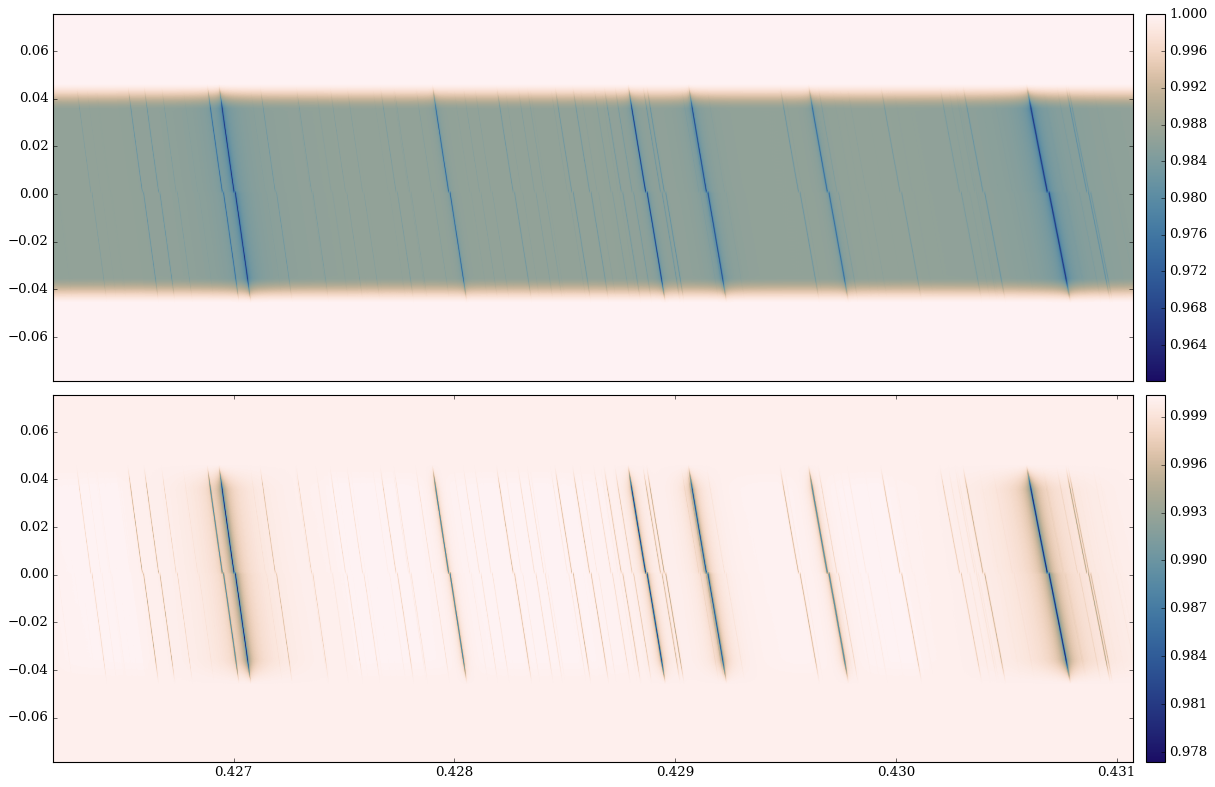

In [11]:
import colormaps as cmaps

output_path = "./CC_output/WASP-121b-injection/"
os.makedirs(output_path, exist_ok=True)
fig, axes = plt.subplots(2, 1, figsize=(17, 2 * 5))
order_i = 15
order_to_plot = models_shifted[order_i]
wl_to_plot = wl_grid[order_i]
im0 = axes[0].imshow(
    order_to_plot,
    aspect="auto",
    origin="lower",
    cmap=cmaps.lapaz,
    vmin=np.min(order_to_plot) * 0.995,
    vmax=np.max(order_to_plot),
    extent=[np.min(wl_to_plot), np.max(wl_to_plot), np.min(phi), np.max(phi)],
)
axes[0].xaxis.set_visible(False)
cbar = fig.colorbar(im0, ax=axes[0], orientation="vertical", pad=0.01)
cbar.formatter.set_useOffset(False)

im1 = axes[1].imshow(
    (order_to_plot.T / np.median(order_to_plot, axis=1)).T,
    aspect="auto",
    origin="lower",
    cmap=cmaps.lapaz,
    vmin=np.min(
        (order_to_plot.T / np.median(order_to_plot, axis=1)).T,
    )
    * 0.999,
    vmax=np.max(
        (order_to_plot.T / np.median(order_to_plot, axis=1)).T,
    ),
    extent=[np.min(wl_to_plot), np.max(wl_to_plot), np.min(phi), np.max(phi)],
)

cbar = fig.colorbar(im1, ax=axes[1], orientation="vertical", pad=0.01)
cbar.formatter.set_useOffset(False)
plt.ticklabel_format(useOffset=False)
plt.tight_layout()

In [12]:
from scipy.ndimage import gaussian_filter1d, median_filter

C[C < 0] = 0
data_injected_raw = C * models_shifted
continuum = np.zeros(data_injected_raw.shape)
for k in range(N_order):
    order = data_injected_raw[k]
    middle = np.median(order, axis=0)
    middle[middle == 0] = np.mean(middle)  # dummy value
    order_norm = order / middle
    continuum[k] = order_norm

for det in range(N_order):
    for p in range(N_phi):
        continuum[det][p] = median_filter(continuum[det][p], size=501)

for det in range(N_order):
    for p in range(N_phi):
        continuum[det][p] = gaussian_filter1d(continuum[det][p], sigma=100)

data_blazed_corrected = data_injected_raw / continuum

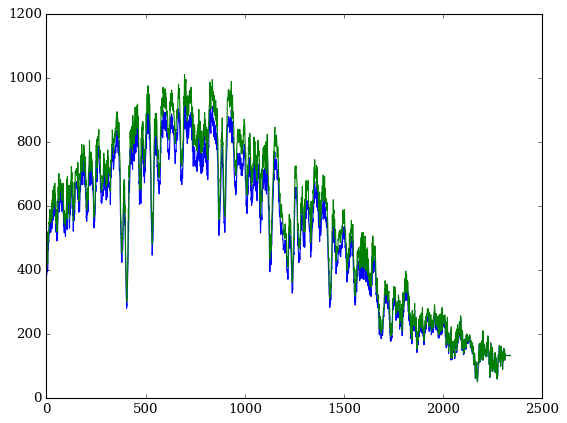

In [13]:
plt.plot(data_blazed_corrected[order_i][0])
plt.plot(C[order_i][0])

In [14]:
uncertainties = fit_uncertainties(
    data_blazed_corrected, NPC=5
)  # add arguments for initial guess

0.385583298247298 232.04464227071017
0.37305038313284544 255.32337624961866
0.35913264464557526 259.6678125116431
0.38428409556135246 254.28600482093162
0.3544594683580355 263.07451093772
0.3864134629828974 253.0742496391142
0.3908830182409847 255.15580133834732
0.39376693341569957 249.70030224130804
0.3697539929245581 255.95861794726088
0.35031551812487693 261.17761994168114
0.3508958980952254 259.824950204122
0.35351666499883505 255.6715702421257
0.33639503181191266 263.13357775671693
0.3117899771313266 270.50558556156466
0.32443331876130077 262.62300758371674
0.32325489617486336 262.10360678390407
0.32682233512974446 259.7231033688254
0.2975654797346563 275.1862481028868
0.29071145781373253 281.32475055112997
0.29274256885163175 276.866490492881
0.29473113972526865 274.8065253789109
0.2975595627998334 271.82845483934824
0.2846308192502377 280.6271967572186
0.29655051708759783 272.83274020226406
0.2989091665951267 266.5611429476094
0.30976165464339955 258.9669018121831
0.318156710694

In [15]:
from POSEIDON.high_res import fast_filter

data_injected_blaze_corrected_norm = np.zeros_like(data_blazed_corrected)
uncertainties_norm = np.zeros_like(uncertainties)
for i in range(N_order):
    order = data_blazed_corrected[i]
    median = np.median(order, axis=0)
    median[median == 0] = np.mean(median)
    order_norm = order / median

    uncertainty = uncertainties[i]
    uncertainty_norm = uncertainty / median

    uncertainties_norm[i] = uncertainty_norm
    data_injected_blaze_corrected_norm[i] = order_norm

residuals, Us = fast_filter(
    data_injected_blaze_corrected_norm, uncertainties_norm, N_iter=15
)

In [16]:
output_data_dir = "./data/WASP-121b-injection-a10/"
pickle.dump(
    uncertainties_norm,
    open(output_data_dir + "/uncertainties.pic", "wb"),
)

pickle.dump(
    [wl_grid, None],
    open(output_data_dir + "/data_raw.pic", "wb"),
)

In [17]:
N_order, N_phi, N_wl = C.shape
Bs = np.zeros((N_order, N_phi, N_phi))

for j in range(N_order):
    U = Us[j]
    L = np.diag(1 / np.mean(uncertainties[j], axis=-1))
    B = U @ np.linalg.pinv(L @ U) @ L
    Bs[j] = B

In [18]:
# plt.figure(figsize=(17, 5))
# plt.plot(wl_grid[0], residuals[15][100])
# plt.ticklabel_format(useOffset=False)

In [19]:
B = Bs[order_i]
model_to_plot = models_shifted[order_i]
model_to_plot = (model_to_plot.T / np.median(model_to_plot, axis=1)).T
model_to_plot = model_to_plot - B @ model_to_plot

In [20]:
residuals_to_plot = residuals[order_i]

In [21]:
pickle.dump([Bs, residuals], open(output_data_dir + "/fast_filter.pic", "wb"))

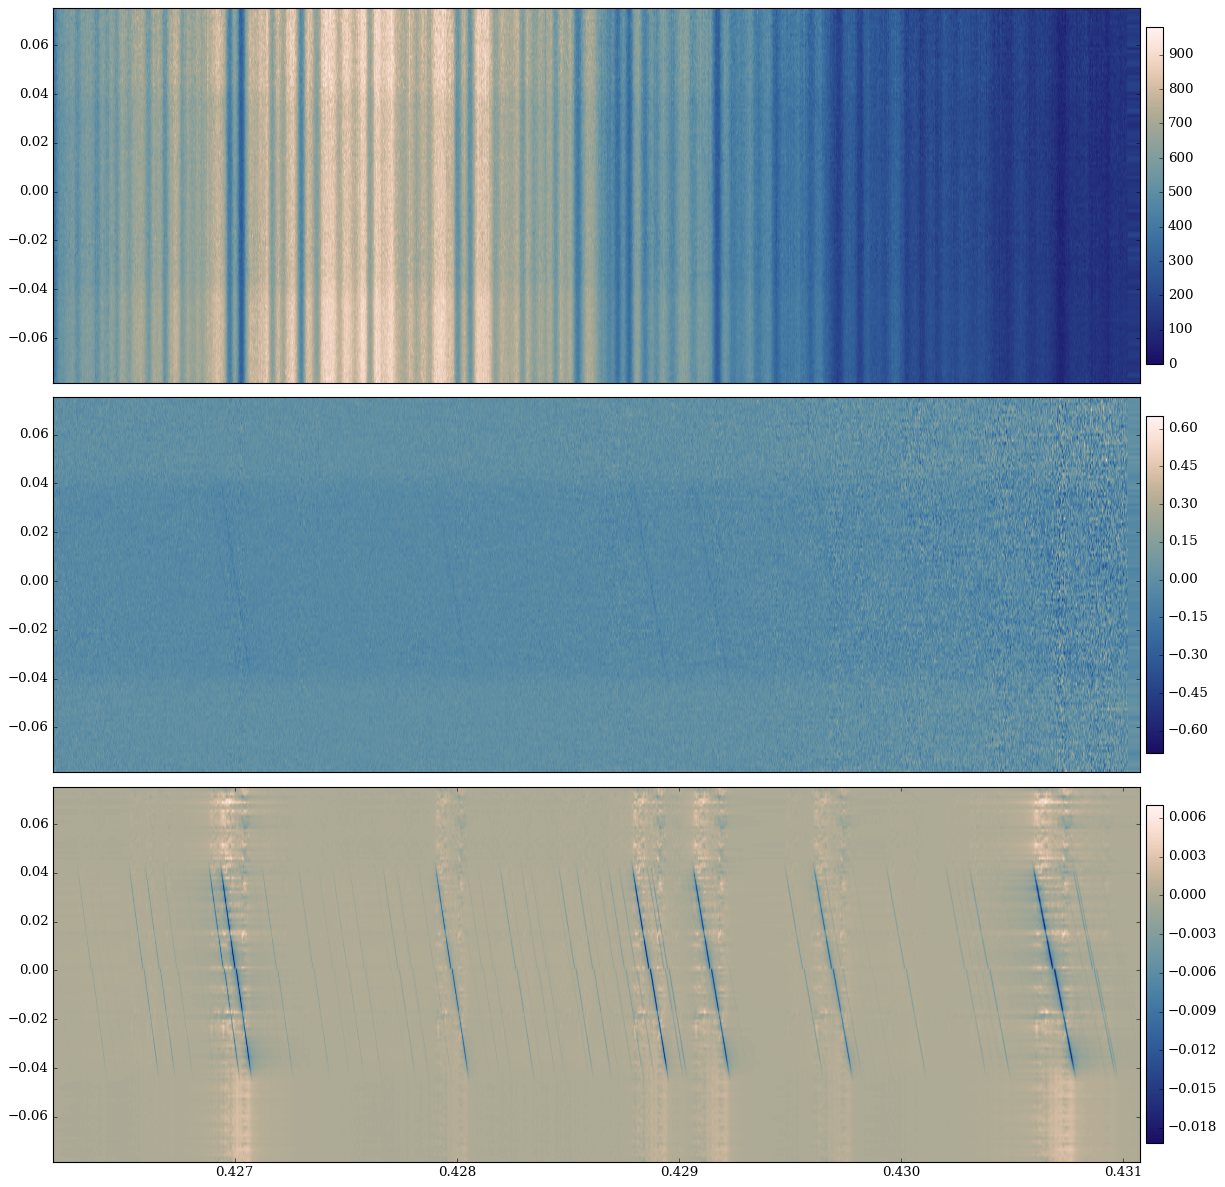

In [22]:
import colormaps as cmaps

phi = pickle.load(open("./data/WASP-121b/phi.pic", "rb"))
output_path = "./CC_output/WASP-121b-injection/"
os.makedirs(output_path, exist_ok=True)

num_plots = 3

fig, axes = plt.subplots(num_plots, 1, figsize=(17, num_plots * 5))
order_i = 15
order_to_plot = data_blazed_corrected[order_i]
wl_to_plot = wl_grid[order_i]

im0 = axes[0].imshow(
    order_to_plot * models_shifted[order_i] ** 3,
    # order_to_plot,
    aspect="auto",
    origin="lower",
    cmap=cmaps.lapaz,
    vmin=0,
    # vmax=vmax,
    extent=[np.min(wl_to_plot), np.max(wl_to_plot), np.min(phi), np.max(phi)],
)

fig.colorbar(
    im0, ax=axes[0], orientation="vertical", pad=0.005, shrink=0.9
).formatter.set_useOffset(False)

for i in range(num_plots - 1):
    axes[i].xaxis.set_visible(False)


im1 = axes[1].imshow(
    (residuals_to_plot + 1) * models_shifted[order_i] ** 3 - 1,
    # residuals_to_plot,
    aspect="auto",
    origin="lower",
    cmap=cmaps.lapaz,
    # vmin=np.min(residuals_to_plot * models_shifted[order_i] ** 3) * 0.999,
    # vmax=np.max(residuals_to_plot * models_shifted[order_i] ** 3) * 1.001,
    extent=[np.min(wl_to_plot), np.max(wl_to_plot), np.min(phi), np.max(phi)],
)

fig.colorbar(
    im1, ax=axes[1], orientation="vertical", pad=0.005, shrink=0.9
).formatter.set_useOffset(False)

im2 = axes[2].imshow(
    model_to_plot,
    aspect="auto",
    origin="lower",
    cmap=cmaps.lapaz,
    # vmin=vmin,
    # vmax=vmax,
    extent=[np.min(wl_to_plot), np.max(wl_to_plot), np.min(phi), np.max(phi)],
)

fig.colorbar(
    im2, ax=axes[2], orientation="vertical", pad=0.005, shrink=0.9
).formatter.set_useOffset(False)


# im3 = axes[3].imshow(
#     residuals[order_i],
#     aspect="auto",
#     origin="lower",
#     cmap=cmaps.lapaz,
#     vmin=np.min(residuals[order_i]) * 0.999,
#     vmax=np.max(residuals[order_i]) * 1.001,
#     extent=[np.min(wl_to_plot), np.max(wl_to_plot), np.min(phi), np.max(phi)],
# )

plt.tight_layout()
# fig.subplots_adjust(hspace=0.02)


plt.ticklabel_format(useOffset=False)

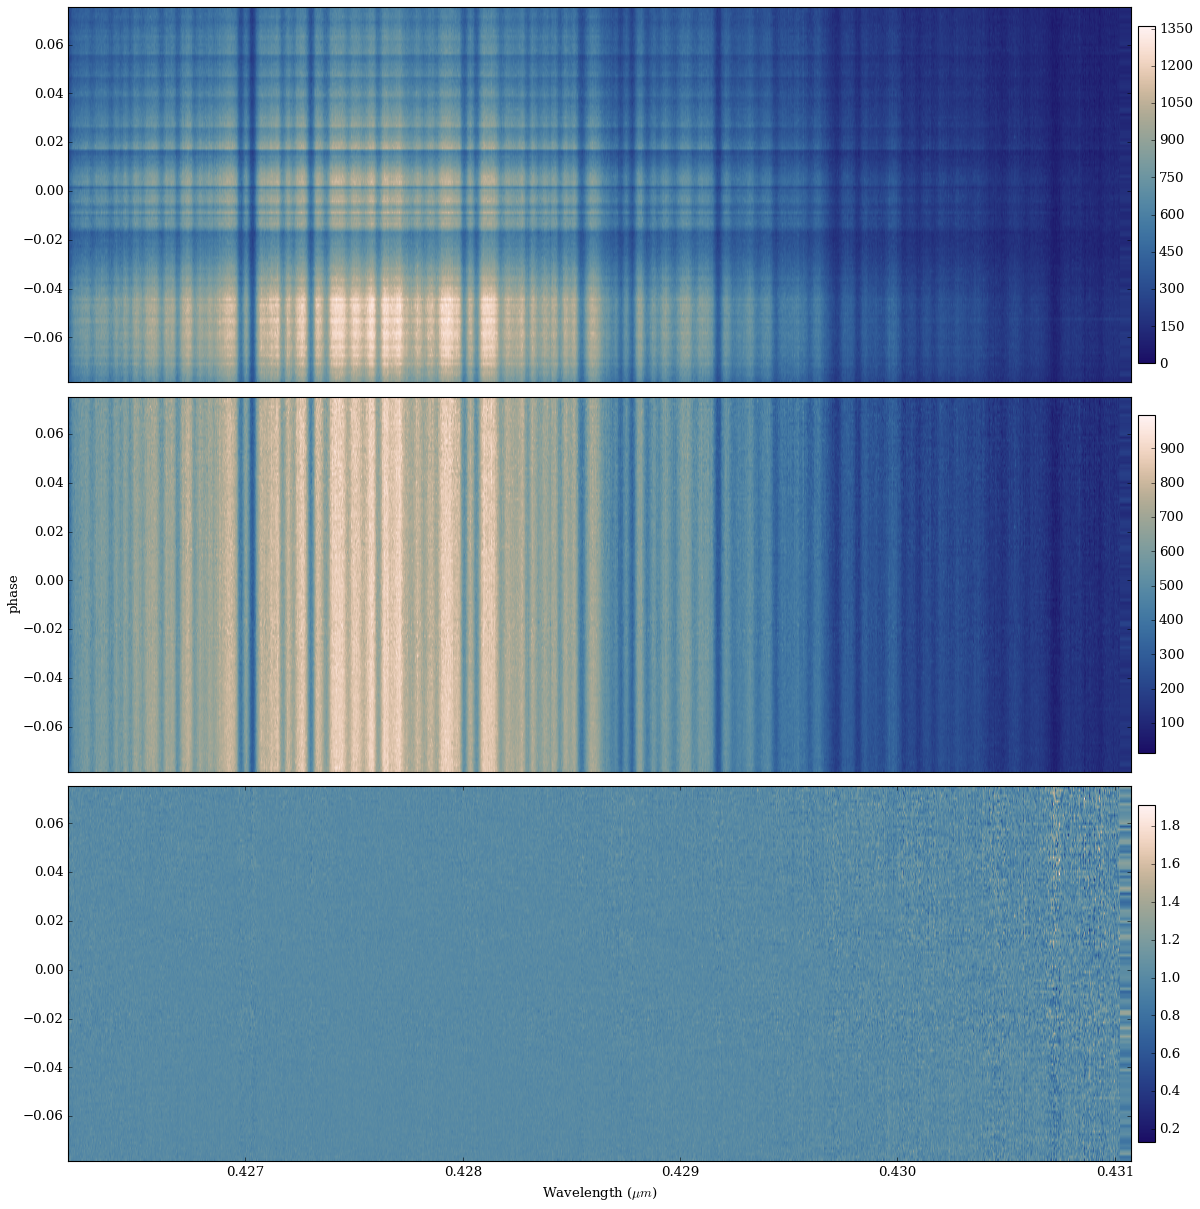

In [23]:
import colormaps as cmaps

phi = pickle.load(open("./data/WASP-121b/phi.pic", "rb"))
output_path = "./CC_output/WASP-121b-injection-a10/"
os.makedirs(output_path, exist_ok=True)

num_plots = 3

fig, axes = plt.subplots(num_plots, 1, figsize=(17, num_plots * 5))
order_i = 15
wl_to_plot = wl_grid[order_i]

im0 = axes[0].imshow(
    # order_to_plot * models_shifted[order_i] ** 3,
    C[order_i],
    aspect="auto",
    origin="lower",
    cmap=cmaps.lapaz,
    vmin=0,
    # vmax=vmax,
    extent=[np.min(wl_to_plot), np.max(wl_to_plot), np.min(phi), np.max(phi)],
)

fig.colorbar(
    im0, ax=axes[0], orientation="vertical", pad=0.005, shrink=0.9
).formatter.set_useOffset(False)

for i in range(num_plots - 1):
    axes[i].xaxis.set_visible(False)


im1 = axes[1].imshow(
    # (residuals_to_plot + 1) * models_shifted[order_i]**3 - 1,
    data_blazed_corrected[order_i],
    aspect="auto",
    origin="lower",
    cmap=cmaps.lapaz,
    # vmin=np.min(residuals_to_plot * models_shifted[order_i] ** 3) * 0.999,
    # vmax=np.max(residuals_to_plot * models_shifted[order_i] ** 3) * 1.001,
    extent=[np.min(wl_to_plot), np.max(wl_to_plot), np.min(phi), np.max(phi)],
)

fig.colorbar(
    im1, ax=axes[1], orientation="vertical", pad=0.005, shrink=0.9
).formatter.set_useOffset(False)

im2 = axes[2].imshow(
    data_injected_blaze_corrected_norm[order_i],
    aspect="auto",
    origin="lower",
    cmap=cmaps.lapaz,
    # vmin=vmin,
    # vmax=vmax,
    extent=[np.min(wl_to_plot), np.max(wl_to_plot), np.min(phi), np.max(phi)],
)

fig.colorbar(
    im2, ax=axes[2], orientation="vertical", pad=0.005, shrink=0.9
).formatter.set_useOffset(False)


# im3 = axes[3].imshow(
#     residuals[order_i],
#     aspect="auto",
#     origin="lower",
#     cmap=cmaps.lapaz,
#     vmin=np.min(residuals[order_i]) * 0.999,
#     vmax=np.max(residuals[order_i]) * 1.001,
#     extent=[np.min(wl_to_plot), np.max(wl_to_plot), np.min(phi), np.max(phi)],
# )
fig.supylabel("phase")
plt.tight_layout()
# fig.subplots_adjust(hspace=0.02)
plt.xlim(np.min(wl_to_plot), np.max(wl_to_plot))
plt.xlabel(r"Wavelength ($\mu m$)")

plt.ticklabel_format(useOffset=False)

In [24]:
data_noiseless = np.ones_like(data_blazed_corrected) * 500
data_noiseless = data_noiseless * models_shifted
uncertainties = np.ones_like(data_blazed_corrected)

In [25]:
from POSEIDON.high_res import fast_filter

data_noiseless_norm = np.zeros_like(data_blazed_corrected)
uncertainties_norm = np.zeros_like(uncertainties)
for i in range(N_order):
    order = data_noiseless[i]
    median = np.median(order, axis=0)
    median[median == 0] = np.mean(median)
    order_norm = order / median

    uncertainty = uncertainties[i]
    uncertainty_norm = uncertainty / median

    uncertainties_norm[i] = uncertainty_norm
    data_noiseless_norm[i] = order_norm

residuals, Us = fast_filter(data_noiseless_norm, uncertainties_norm, N_iter=15)

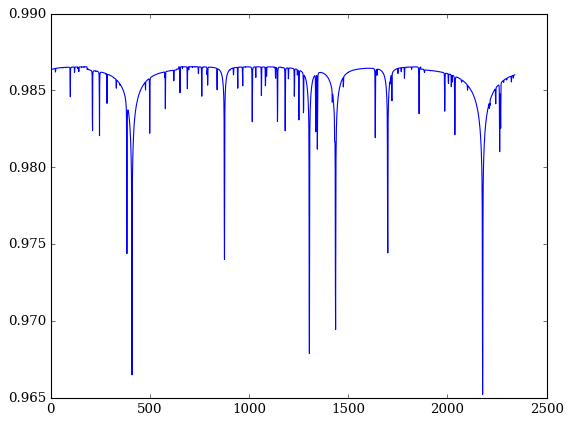

In [26]:
plt.plot(models_shifted[order_i][50])
plt.ticklabel_format(useOffset=False)

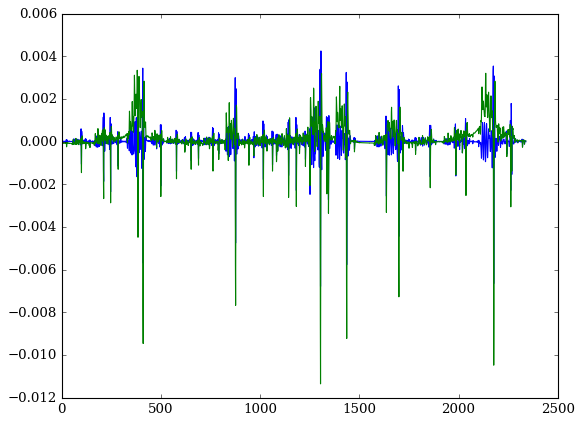

In [27]:
plt.plot(residuals[order_i][50])
plt.plot(model_to_plot[50])